In [1]:
##### -*-coding:utf-8 -*-
# import all the libraries 
# python==3.10; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
from __future__ import division
import os
from sympy import *
from sympy import coth
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nptdms import TdmsFile
from more_itertools import chunked
# %pip install -q ipywidgets
# %pip install --upgrade pip
%matplotlib widget
# %matplotlib inline

In [2]:
import sys
print(sys.executable)

/Users/longfu/.pyenv/versions/3.10.6/bin/python


In [47]:
# read raw .tdms file with TdmsFile function
# name example: 20200304-160513 10pN- 30nM DNAp + 0.1mg_mL_BSA #019-002
# name = input('please type in the file name:' ) + '.tdms'
# # path example: C:\Users\12345\Desktop
# path = input('please type in the file path:')
# filename = os.path.join(path, name) 
filename = input('please type in the file name with absolute path:' )
tdms_file = TdmsFile(filename)


# please write down the starting time of exo and pol, the ending time of exo and pol

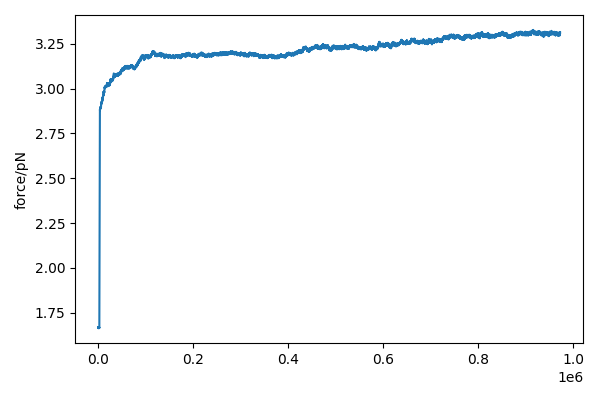

In [50]:
# run this step to find out the Time of ROI
time = tdms_file['FD Data']['Time (ms)'][:]
time = np.array(time)
force = tdms_file['FD Data']['Force Channel 0 (pN)'][:]
force = np.array(force)
distance = tdms_file['FD Data']['Distance 1 (um)'][:]
distance = np.array(distance)

# run this step to find out the Time of ROI
plt.figure(figsize=(6,4))
# plt.plot(time,force)
plt.plot(time,distance)
# plt.plot(distance,force)
plt.ylabel('force/pN')
plt.tight_layout()
plt.show()


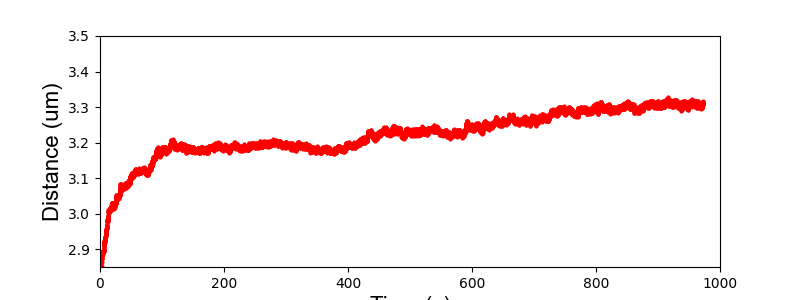

In [56]:
# plt.figure(figsize=(8,3))
# font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

# plt.plot(time/1000,distance-1.78,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2)

# # plt.title('Experimental Data fit to tWLC and FJC Model',fontdict=font)
# plt.ylim(2.85,3.5)
# plt.xlim(0,1000)
# plt.ylabel('Distance (um)',fontdict=font)
# plt.xlabel('Time (s)',fontdict=font)

# plt.show()
# plt.tight_layout()
# plt.savefig('Figure S2'+'.eps', dpi=300)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed

# Assuming you already have the data loaded from the tdms file
time = tdms_file['FD Data']['Time (ms)'][:]
time = np.array(time)
force = tdms_file['FD Data']['Force Channel 0 (pN)'][:]
force = np.array(force)
distance = tdms_file['FD Data']['Distance 1 (um)'][:]
distance = np.array(distance)

# Define a function to create the plot
def plot_force_time(roi_start, roi_end):
    plt.figure(figsize=(6, 4))
    plt.plot(time, force)
    # plt.axvspan(roi_start, roi_end, alpha=0.3, color='red')
    plt.ylabel('force/pN')
    plt.xlabel('time/ms')
    plt.tight_layout()
    plt.show()

# Define the interactive widget
interactive_plot = interactive(
    plot_force_time,
    roi_start=(time.min(), time.max(), 1),  # Adjust the step size as needed
    roi_end=(time.min(), time.max(), 1)     # Adjust the step size as needed
)

# Display the interactive widget
interactive_plot


interactive(children=(FloatSlider(value=398156.0, description='roi_start', max=796264.0, min=48.0, step=1.0), …

In [6]:
# please enter cycle number of interest
cycle = input('please type in cycle number of interest(e.g.:01):')

# time_from_all = float(input('please type in the starting time of interest:'))
# time_to_all = float(input('please type in the ending time of interest:'))

time_from_exo = float(input('please type in the starting time of exo in ms:'))
time_to_exo = float(input('please type in the ending time of exo in ms:'))

time_from_pol = float(input('please type in the starting time of pol in ms:'))
time_to_pol = float(input('please type in the ending time of pol in ms:'))

In [7]:
# here you will select and analyze your interesting cycle with corresponding time range; 
# define a temporary index to compute time of ROI, and subsuquent ROI of force, distance
# indtemp_all = np.where((time <= time_to_all) & (time >= time_from_all))
indtemp_exo = np.where((time <= time_to_exo) & (time >= time_from_exo))
indtemp_pol = np.where((time <= time_to_pol) & (time >= time_from_pol))

# # all time range of event
# time_range_all = time[indtemp_all]
# force_range_all = force[indtemp_all]
# distance_range_all = distance[indtemp_all]

# exo time range of ROI
time_range_exo = time[indtemp_exo]
force_range_exo = force[indtemp_exo]
distance_range_exo = distance[indtemp_exo]

# pol time range of ROI
time_range_pol = time[indtemp_pol]
force_range_pol = force[indtemp_pol]
distance_range_pol = distance[indtemp_pol]

# all time range of ROI
time_range_all = np.append(time_range_exo, time_range_pol)
force_range_all = np.append(force_range_exo, force_range_pol)
distance_range_all = np.append(distance_range_exo, distance_range_pol)

In [8]:
# parameters for tWLC model: Peter Gross, et al. Nature Physics volume 7, pages731–736(2011)
# dsDNA contour length Lc = 2.85056um; persistent length Lp = 56nm
# the twist rigidity C=440 pN nm2;
# the stretching modulus S=1500 pN;
# the twist–stretch coupling g(F) is given by: g(F) =g0+g1F,where g0=−637 pN nm, g1=17 nm
EEDds,Lc,F,Lp,C,g0,g1,S = symbols('EEDds Lc F Lp C g0 g1 S', real=True)
C = 440
g0= -637
g1 = 17
Lc = 2.85056
Lp = 56
S = 1500
# tWLC model expression:
def tWLC(F):
    EEDds = Lc*(1-0.5*(4.1/(F*Lp))**0.5 + C*F/(-(g0+g1*F)**2 + S*C))
    return (EEDds)

# parameters for FJC model: Smith, S. B., et al. Science 271, 795–799 (1996).
# ssDNA contour length Lss = 4.69504um,
# Kuhn length b = 1.5nm (persistent length is 0.75nm),
# the stretching modulus S=800pN
EEDss,Lss,b,Sss = symbols('EEDss Lss b Sss', real=True)
Lss = 4.69504
b = 1.5
Sss = 800
# FJC model expression:
def FJC(F):
    EEDss = []
    for Fext in F:
        x  = Lss * (coth(Fext * b / 4.1) - 4.1 / (Fext * b)) * (1 + Fext / Sss)
        EEDss.append(x)
    EEDss = np.array(EEDss)
    return (EEDss)

# EEDss,Lss,b,Sss,Fext = symbols('EEDss Lss b Sss Fext', real=True)
# Lss = 4.69504
# b = 1.5
# Sss = 800
# # FJC model expression:
# def FJC(Fext):
#     EEDss  = Lss * (coth(Fext * b / 4.1) - 4.1 / (Fext * b)) * (1 + Fext / Sss)
#     return (EEDss)

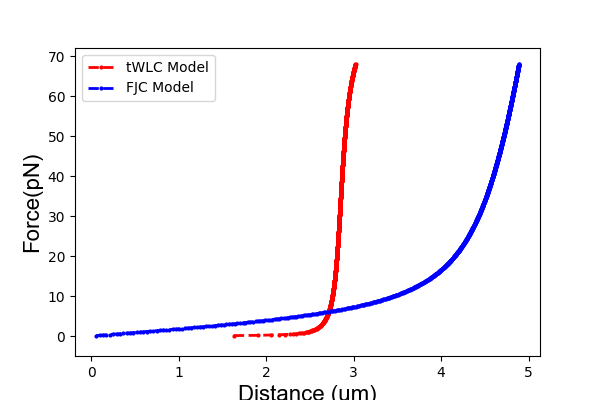

In [9]:
Force = np.linspace(0.1,68,1000)

plt.figure(figsize=(6,4))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}


plt.xlabel('Distance (um)',fontdict=font)
plt.ylabel('Force(pN)',fontdict=font)
plt.plot(tWLC(Force),Force,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='tWLC Model')
plt.plot(FJC(Force),Force,color='b', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='FJC Model')

plt.legend()
# plt.title('Experimental Data fit to tWLC and FJC Model',fontdict=font)
plt.ylim(-5,72)

plt.show()
plt.tight_layout()

# you can only see experimental data after you run the next code block 

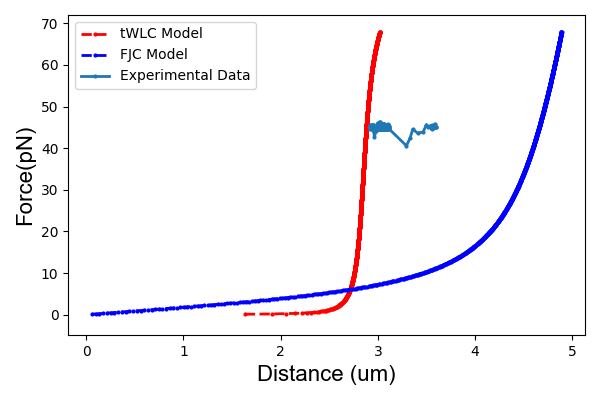

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
# Default bead size = 1.76um, by running this code to fit the right bead size
bead_size = 1.82

# plot experimental data together with 
plt.plot(distance_range_all - bead_size, force_range_all, marker='o', linestyle='solid',linewidth=2, markersize=2,label='Experimental Data')
plt.legend()
plt.tight_layout()
plt.show()
    
plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-DataFit2Model'+'.eps', dpi=300)

End-to-end distance between two optically trapped beads consists ssDNA fraction and dsDNA fraction. By calculating:
- *ssDNA percentage* : ssDNA % =(𝐸𝐸𝐷 −𝑡𝑊𝐿𝐶(𝐹))/(𝐹𝐽𝐶(𝐹)  −𝑡𝑊𝐿𝐶(𝐹))
- *dsDNA percentage* : dsDNA % =1-ssDNA % , 
- *ssDNA/dsDNA junction position* could be obtained following: Junction position =(𝑠𝑠% ∗𝐹𝐽𝐶(𝐹))/(𝑠𝑠% ∗𝐹𝐽𝐶(𝐹)+𝑑𝑠% ∗𝑒𝑊𝐿𝐶(𝐹) ) * EED). 

Junction position changes is then plotted as a function of time.

In [12]:
# Default exo_force is 50pN and pol_force 20pN 
exo_force = 45
pol_force = 20

# calculating the length of dsDNA under exo and pol force
dsDNA_exo_ref = tWLC(exo_force)
dsDNA_pol_ref = tWLC(pol_force)

# calculating the length of ssDNA under exo and pol force
ssDNA_exo_ref = 4.69504 * (coth(exo_force * 1.5 / 4.1) - 4.1 / (exo_force * b)) * (1 + exo_force / 800)
ssDNA_pol_ref =4.69504 * (coth(pol_force * 1.5 / 4.1) - 4.1 / (pol_force * b)) * (1 + pol_force / 800)

In [13]:
# calculating ssDNA under exo and pol force
ssDNA_exo_percentage = (distance_range_exo - bead_size - dsDNA_exo_ref)/(ssDNA_exo_ref - dsDNA_exo_ref)
ssDNA_pol_percentage = (distance_range_pol - bead_size - dsDNA_pol_ref)/(ssDNA_pol_ref - dsDNA_pol_ref)
ssDNA_all_percentage = np.append(ssDNA_exo_percentage,ssDNA_pol_percentage)

# calculating basepairs
# Construct of pkyb1 DNA has a length of 8393bp
basepairs = (1-ssDNA_all_percentage) * 8393

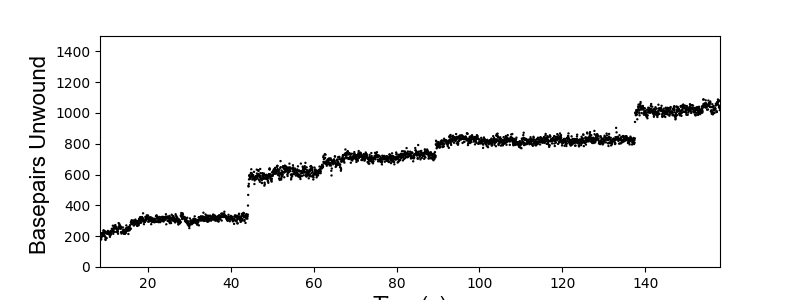

In [36]:
# plot ssDNA% as a function of time
plt.figure(figsize=(8,3))
# font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

plt.ylabel('Basepairs Unwound ',fontdict=font)
plt.xlabel('Time(s)',fontdict=font)
plt.scatter(time_range_all/1000,ssDNA_all_percentage  * 8393,color='black', linestyle='dashed',s=0.5,label='End-to-End Distance')
plt.ylim(0,1500)


# plt.legend()
# plt.ylim(0,4.3)

# ax = plt.gca()
# ax.invert_yaxis()
# ax.xaxis.set_ticks_position('top')

plt.xlim(8.5,158)
plt.show()
plt.tight_layout()

plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-ssDNA_percentage'+'.eps', dpi=300)

   Distance_(_)  Gray_Value
0             0     24.2121
1             1     21.1515
2             2     20.4545
3             3     20.0606
4             4     18.8788


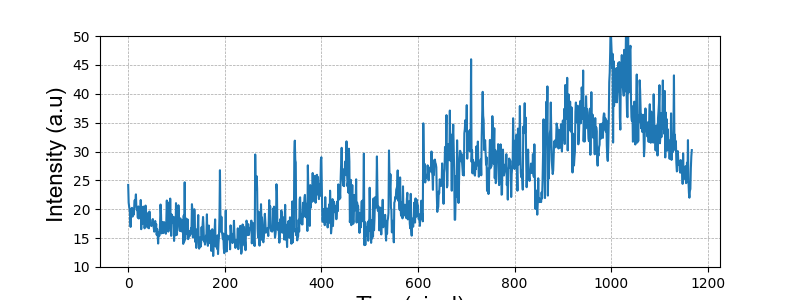

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [46]:
# this code is intended to plot the intensity trace over time
# Replace 'your_file.csv' with the path to your CSV file
csv_file = '/Users/longfu/Library/CloudStorage/Dropbox/5-T7 Helicase-SSB_PNAS/Raw data/Figure S2/Intensity-Values.csv'

# Load the data from the CSV file into a pandas DataFrame
data = pd.read_csv(csv_file)

# Display the first few rows of the DataFrame
print(data.head())

# # plot ssDNA% as a function of time
plt.figure(figsize=(8,3))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.plot(data['Distance_(_)'], data['Gray_Value'])
plt.ylabel('Intensity (a.u) ',fontdict=font)
plt.xlabel('Time(pixel)',fontdict=font)

# plt.xlim(0,436)
plt.ylim(10,50)


# Add a grid to the plot
plt.grid(True, which='major', axis='x')

# Customize the grid appearance (optional)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()
plt.tight_layout()

plt.savefig(csv_file.replace('.csv', '-intensity-plot') +'.eps', dpi=300)

In [15]:
# calculating ssDNA/dsDNA junction position under exo and pol force
junction_position_exo = (ssDNA_exo_percentage * ssDNA_exo_ref) * (distance_range_exo - bead_size) / ((ssDNA_exo_percentage * ssDNA_exo_ref) + (1 - ssDNA_exo_percentage) * dsDNA_exo_ref)
junction_position_pol = (ssDNA_pol_percentage * ssDNA_pol_ref) * (distance_range_pol - bead_size) / ((ssDNA_pol_percentage * ssDNA_pol_ref) + (1 - ssDNA_pol_percentage) * dsDNA_pol_ref)
junction_position_all = np.append(junction_position_exo, junction_position_pol)

# ## Under some occasions, DNA polymerase starts from the other side, then we need to ajust the above math expression 
# # You need to decide based on the image data
# junction_position_exo = (distance_range_exo - bead_size) - (ssDNA_exo_percentage * ssDNA_exo_ref) * (distance_range_exo - bead_size) / ((ssDNA_exo_percentage * ssDNA_exo_ref) + (1 - ssDNA_exo_percentage) * dsDNA_exo_ref)
# junction_position_pol = (distance_range_pol - bead_size) - (ssDNA_pol_percentage * ssDNA_pol_ref) * (distance_range_pol - bead_size) / ((ssDNA_pol_percentage * ssDNA_pol_ref) + (1 - ssDNA_pol_percentage) * dsDNA_pol_ref)
# junction_position_all = np.append(junction_position_exo, junction_position_pol)

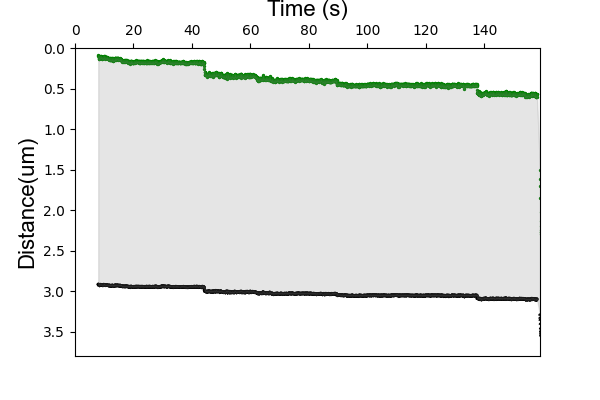

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
# plot DNA polymerase trace as a function of time
plt.figure(figsize=(6,4))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

plt.title('Time (s)',fontdict=font)
plt.ylabel('Distance(um)',fontdict=font)
plt.scatter(time_range_all/1000,distance_range_all - bead_size,color='black', linestyle='dashed',s=2,label='End-to-End Distance')
plt.scatter(time_range_all/1000,junction_position_all,color='green',s=2,label='DNA Polymerase Trace')
junction_position_all = np.array(junction_position_all, dtype=np.float64)
# plt.fill_between(np.array(time_range_all/1000), np.array(junction_position_all),alpha=0.5)
# Fill the area between the two data lines
plt.fill_between(np.array(time_range_all/1000), distance_range_all - bead_size, junction_position_all,color='gray',alpha=0.2)

# plt.legend()
plt.ylim(0,3.8)
plt.xlim(0,159)

ax = plt.gca()
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')


plt.show()
plt.tight_layout()

plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-DNApTraces'+'.eps', dpi=300)

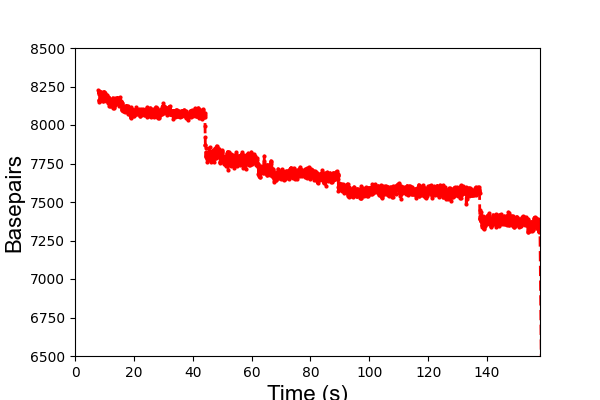

In [17]:
# plot basepair changes as a function of time
plt.figure(figsize=(6,4))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}


plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Basepairs',fontdict=font)
plt.plot(time_range_all/1000,basepairs,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='Basepairs')

# plt.legend()
# plt.title('BasePair Changes as a Function of Time',fontdict=font)
plt.xlim(0,158)
plt.ylim(6500,8500)
plt.show()
plt.tight_layout()

plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-BasepairChange'+'.eps', format='eps', dpi=300, bbox_inches='tight')
# plt.close()

In [18]:
# Save all the analyzed data in an excel file
excel_filename = filename.replace('.tdms', '-cycle#') + cycle + "processedData" + '.xlsx'

data = {'time': time_range_all,
        'ssDNA_all_percentage': ssDNA_all_percentage,
        'junction_position_all': junction_position_all,
        'basepairs': basepairs}
df = pd.DataFrame(data)

with pd.ExcelWriter(excel_filename) as writer:
    df.to_excel(writer)
